# Carrega e Testa Modelos CNN

In [1]:
import pandas as pd
import numpy as np

import tensorflow
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
from PIL import Image
from glob import glob

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from platform import python_version
print('python_version:', python_version())
# 3.6.6

import keras as kr
print('keras: ',kr.__version__)
# '2.3.0'

import tensorflow as tf
print('tensorflow:',tf.__version__)
# '1.14.0'

/Users/vladimiralencar/anaconda3/envs/tf366/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vladimiralencar/anaconda3/envs/tf366/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vladimiralencar/anaconda3/envs/tf366/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/vladimiralen

python_version: 3.6.6
keras:  2.3.0
tensorflow: 1.14.0


Using TensorFlow backend.


# Carrega o modelo CNN criado

In [2]:
!ls model*

model-MacBookPro-i7-16GB-RAM.hdf5 model-kaggle-93acc-v07-adam.hdf5
model-MacBookPro.h5               model-kaggle-93acc.hdf5
model-MacBookPro.hdf5             model-kaggle.hdf5
model-kaggle-93acc-v06-adam.hdf5  model-transfer-learning.hdf5


In [3]:
file = 'model-MacBookPro-i7-16GB-RAM.hdf5'
#file = 'model-kaggle-93acc-v07-adam.hdf5'
#file = 'model-kaggle-93acc-v06-adam.hdf5'
#file = 'model-kaggle-93acc.hdf5'
#file = 'my_model_02-TITAN.hdf5'
#file = 'model-kaggle.hdf5'
#file = 'my_model_02-GoogleColab.hdf5'
classifierLoad = tf.keras.models.load_model(file)
model = classifierLoad
model

# Previsão 1 Imagem

In [4]:
dict_idx_doenca = {0: 'Actinic keratoses',
 1: 'Basal cell carcinoma',
 2: 'Benign keratosis-like lesions ',
 3: 'Dermatofibroma',
 4: 'Melanocytic nevi',
 5: 'Melanoma',
 6: 'Vascular lesions'}
dict_idx_doenca

{0: 'Actinic keratoses',
 1: 'Basal cell carcinoma',
 2: 'Benign keratosis-like lesions ',
 3: 'Dermatofibroma',
 4: 'Melanocytic nevi',
 5: 'Melanoma',
 6: 'Vascular lesions'}

[0.00362961 0.27953446 0.09572408 0.04719473 0.57106984 0.00109547
 0.0017517 ]
Melanocytic nevi 4


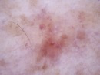

In [5]:
input_shape = (75, 100, 3)
folder_test = 'images_test/'
x = folder_test + 'Actinic-Keratoses.jpg'
x_pred = np.asarray(Image.open(x).resize((100,75)))  

x_pred = x_pred.reshape(1, 75, 100, 3)

x_pred = (x_pred - 127.5) / 127.5 # Normaliza
print(model.predict_proba(x_pred)[0])
pred = np.argmax(model.predict(x_pred))
print(dict_idx_doenca[pred], pred)
Image.open(x).resize((100,75)) 

In [6]:
dict_idx_doenca

{0: 'Actinic keratoses',
 1: 'Basal cell carcinoma',
 2: 'Benign keratosis-like lesions ',
 3: 'Dermatofibroma',
 4: 'Melanocytic nevi',
 5: 'Melanoma',
 6: 'Vascular lesions'}

In [7]:
dict_idx_doenca.items()

dict_items([(0, 'Actinic keratoses'), (1, 'Basal cell carcinoma'), (2, 'Benign keratosis-like lesions '), (3, 'Dermatofibroma'), (4, 'Melanocytic nevi'), (5, 'Melanoma'), (6, 'Vascular lesions')])

# Previsão várias Imagens

In [8]:
def prever_doenca_de_pele(file, fator_normalizacao):
    dict_idx_doenca = {  0: ['Actinic keratoses', 'Queratose Actínica'],
                         1: ['Basal cell carcinoma', 'Carcinoma de Células Basais' ],
                         2: ['Benign keratosis-like lesions ', 'Queratoses Seborréicas'], 
                         3: ['Dermatofibroma', 'Dermatofibroma (Histiocitoma Fibroso Benigno)' ],
                         4: ['Melanocytic nevi', 'Nevo Melanócito (Nevo Pigmentado, Sinal)'],
                         5: [ 'Melanoma', 'Melanoma'],
                         6: ['Vascular lesions', 'Lesões de Pele Vasculares' ]}   
    indices = []
    doencas_en = []
    doencas_pt = []
    for idx, doenca in (dict_idx_doenca.items()):
        indices.append(idx)
        doencas_en.append(doenca[0])
        doencas_pt.append(doenca[1])
     
    #print(doencas_pt)

    #fatores_normalizacao = [127.5, 255]
    #fator_normalizacao = fatores_normalizacao[0]
    #folder_test = 'images_test/'
    #x = folder_test + file
    
    # x_train = (x_train - x_train_mean)/x_train_std
    
    media_scale_image = 161.80099918483077
    std_scale_image = 43.32325199568378
    
    x = file
    x_pred = np.asarray(Image.open(x).resize((100,75)))  

    x_pred = x_pred.reshape(1, 75, 100, 3)
    #x_pred = (x_pred - fator_normalizacao) / fator_normalizacao
    
    x_pred = (x_pred - media_scale_image) / std_scale_image
    

    #print(model.predict(x_pred)[0])
    classe = model.predict_classes(x_pred)[0]
    pred = np.argmax(model.predict(x_pred))
    
    probs = model.predict(x_pred)[0]
    
    df = pd.DataFrame()
    df['prob'] = probs * 100
    df['idx'] = indices
    df['doenca_en'] = doencas_en
    df['doenca_pt'] = doencas_pt
    
    print('Diagnóstico:', dict_idx_doenca[classe][0], '-',  dict_idx_doenca[classe][1])
    print('Observado: ', file.split('/')[1], '>>>> Previsto: ', dict_idx_doenca[classe][0], '-',
        np.round( np.max(model.predict(x_pred))* 100 , 2 ), '%' )
    
    return df

In [9]:
!ls images_test/*.jpg

images_test/Actinic-Keratoses.jpg
images_test/Actinic-Keratosis-01.jpg
images_test/Basal-Cell-Carcinoma-02.jpg
images_test/Basal-Cell-Carcinoma.jpg
images_test/Beggining-Keratosis-Like-Lesions-01.jpg
images_test/Dematofibroma-01.jpg
images_test/Dermatofibroma-01.jpg
images_test/Dermatofibroma-03.jpg
images_test/Dermatofibroma-04.jpg
images_test/Dermatofribroma-02.jpg
images_test/Dermatofribroma-03.jpg
images_test/Lesão-Branquinha-INGRATA-01.jpg
images_test/Vascular Lesions-01.jpg
images_test/Vascular-Lesions-03.jpg
images_test/Vascular-lesions-01.jpg


# Avalia algumas imagens de teste

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}  // disable scrolling cells

<IPython.core.display.Javascript object>

Diagnóstico de Doenças de Pele - Versão 1.0 - By Vladimir Alencar - UEPB-LANA

Diagnóstico: Basal cell carcinoma - Carcinoma de Células Basais
Observado:  Basal-Cell-Carcinoma.jpg >>>> Previsto:  Basal cell carcinoma - 77.53 %


,doenca_en,prob
1,Basal cell carcinoma,77.527
6,Vascular lesions,5.368
3,Dermatofibroma,4.891
0,Actinic keratoses,3.945
4,Melanocytic nevi,3.863
5,Melanoma,2.764
2,Benign keratosis-like lesions,1.643


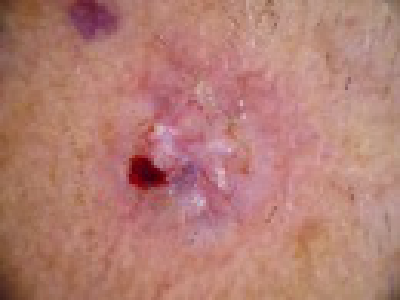

Diagnóstico: Basal cell carcinoma - Carcinoma de Células Basais
Observado:  Basal-Cell-Carcinoma-02.jpg >>>> Previsto:  Basal cell carcinoma - 42.99 %


,doenca_en,prob
1,Basal cell carcinoma,42.991
3,Dermatofibroma,20.824
0,Actinic keratoses,18.146
4,Melanocytic nevi,6.569
2,Benign keratosis-like lesions,6.568
6,Vascular lesions,3.843
5,Melanoma,1.059


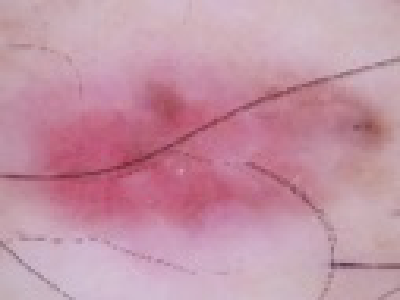

Diagnóstico: Melanocytic nevi - Nevo Melanócito (Nevo Pigmentado, Sinal)
Observado:  Dermatofibroma-04.jpg >>>> Previsto:  Melanocytic nevi - 47.1 %


,doenca_en,prob
4,Melanocytic nevi,47.103
2,Benign keratosis-like lesions,41.313
5,Melanoma,9.298
1,Basal cell carcinoma,1.203
3,Dermatofibroma,0.882
0,Actinic keratoses,0.130
6,Vascular lesions,0.071


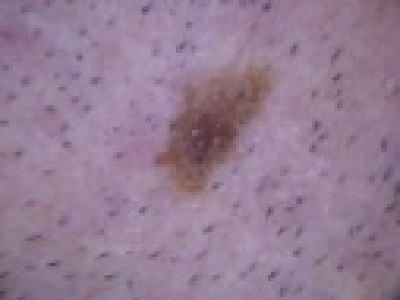

Diagnóstico: Melanocytic nevi - Nevo Melanócito (Nevo Pigmentado, Sinal)
Observado:  Beggining-Keratosis-Like-Lesions-01.jpg >>>> Previsto:  Melanocytic nevi - 43.63 %


,doenca_en,prob
4,Melanocytic nevi,43.626
2,Benign keratosis-like lesions,39.095
5,Melanoma,13.157
1,Basal cell carcinoma,1.932
0,Actinic keratoses,1.206
3,Dermatofibroma,0.900
6,Vascular lesions,0.083


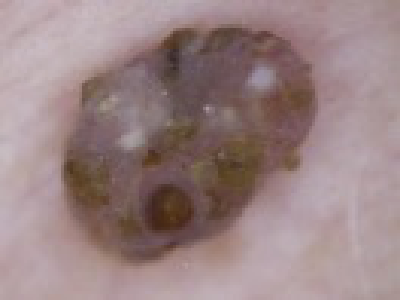

Diagnóstico: Melanocytic nevi - Nevo Melanócito (Nevo Pigmentado, Sinal)
Observado:  Dermatofibroma-01.jpg >>>> Previsto:  Melanocytic nevi - 54.55 %


,doenca_en,prob
4,Melanocytic nevi,54.546
2,Benign keratosis-like lesions,16.416
1,Basal cell carcinoma,13.715
5,Melanoma,8.975
3,Dermatofibroma,3.143
0,Actinic keratoses,2.207
6,Vascular lesions,0.997


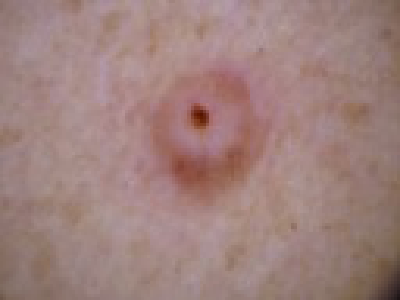

Diagnóstico: Basal cell carcinoma - Carcinoma de Células Basais
Observado:  Dermatofribroma-02.jpg >>>> Previsto:  Basal cell carcinoma - 36.58 %


,doenca_en,prob
1,Basal cell carcinoma,36.577
0,Actinic keratoses,22.674
2,Benign keratosis-like lesions,14.208
3,Dermatofibroma,12.598
4,Melanocytic nevi,10.913
5,Melanoma,2.204
6,Vascular lesions,0.827


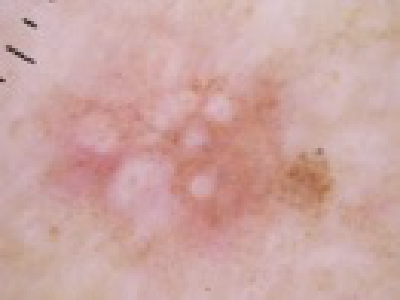

Diagnóstico: Melanocytic nevi - Nevo Melanócito (Nevo Pigmentado, Sinal)
Observado:  Dermatofibroma-03.jpg >>>> Previsto:  Melanocytic nevi - 54.55 %


,doenca_en,prob
4,Melanocytic nevi,54.546
2,Benign keratosis-like lesions,16.416
1,Basal cell carcinoma,13.715
5,Melanoma,8.975
3,Dermatofibroma,3.143
0,Actinic keratoses,2.207
6,Vascular lesions,0.997


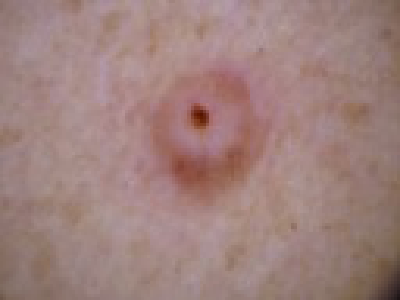

Diagnóstico: Melanocytic nevi - Nevo Melanócito (Nevo Pigmentado, Sinal)
Observado:  Dermatofribroma-03.jpg >>>> Previsto:  Melanocytic nevi - 52.05 %


,doenca_en,prob
4,Melanocytic nevi,52.048
2,Benign keratosis-like lesions,27.909
5,Melanoma,10.713
1,Basal cell carcinoma,3.646
3,Dermatofibroma,3.323
0,Actinic keratoses,1.903
6,Vascular lesions,0.458


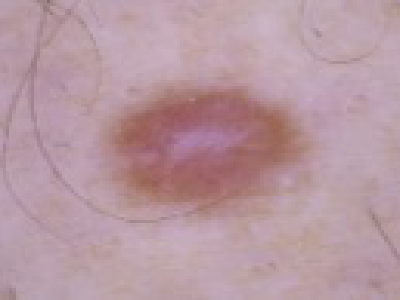

Diagnóstico: Melanocytic nevi - Nevo Melanócito (Nevo Pigmentado, Sinal)
Observado:  Lesão-Branquinha-INGRATA-01.jpg >>>> Previsto:  Melanocytic nevi - 42.57 %


,doenca_en,prob
4,Melanocytic nevi,42.573
1,Basal cell carcinoma,28.335
2,Benign keratosis-like lesions,17.725
0,Actinic keratoses,5.200
3,Dermatofibroma,4.989
5,Melanoma,1.095
6,Vascular lesions,0.084


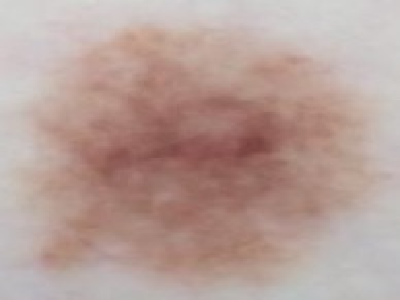

Diagnóstico: Benign keratosis-like lesions  - Queratoses Seborréicas
Observado:  Actinic-Keratosis-01.jpg >>>> Previsto:  Benign keratosis-like lesions  - 23.33 %


,doenca_en,prob
2,Benign keratosis-like lesions,23.333
0,Actinic keratoses,20.626
4,Melanocytic nevi,18.831
1,Basal cell carcinoma,16.937
5,Melanoma,13.046
3,Dermatofibroma,6.594
6,Vascular lesions,0.633


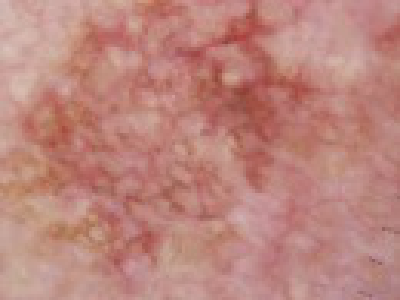

Diagnóstico: Melanocytic nevi - Nevo Melanócito (Nevo Pigmentado, Sinal)
Observado:  Vascular-Lesions-03.jpg >>>> Previsto:  Melanocytic nevi - 57.22 %


,doenca_en,prob
4,Melanocytic nevi,57.221
6,Vascular lesions,14.852
5,Melanoma,10.453
2,Benign keratosis-like lesions,8.669
1,Basal cell carcinoma,6.214
3,Dermatofibroma,1.551
0,Actinic keratoses,1.040


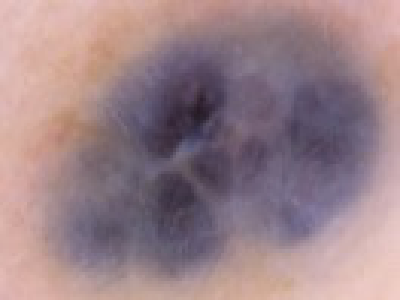

Diagnóstico: Melanocytic nevi - Nevo Melanócito (Nevo Pigmentado, Sinal)
Observado:  Vascular-lesions-01.jpg >>>> Previsto:  Melanocytic nevi - 40.52 %


,doenca_en,prob
4,Melanocytic nevi,40.520
1,Basal cell carcinoma,26.437
3,Dermatofibroma,20.528
2,Benign keratosis-like lesions,7.642
6,Vascular lesions,4.447
5,Melanoma,0.245
0,Actinic keratoses,0.181


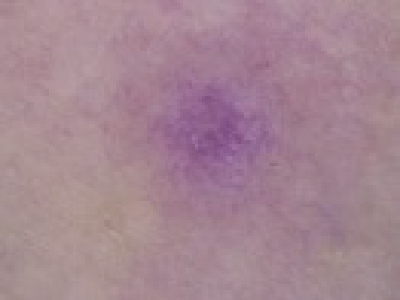

Diagnóstico: Vascular lesions - Lesões de Pele Vasculares
Observado:  Vascular Lesions-01.jpg >>>> Previsto:  Vascular lesions - 100.0 %


,doenca_en,prob
6,Vascular lesions,100.000
4,Melanocytic nevi,0.000
5,Melanoma,0.000
1,Basal cell carcinoma,0.000
2,Benign keratosis-like lesions,0.000
3,Dermatofibroma,0.000
0,Actinic keratoses,0.000


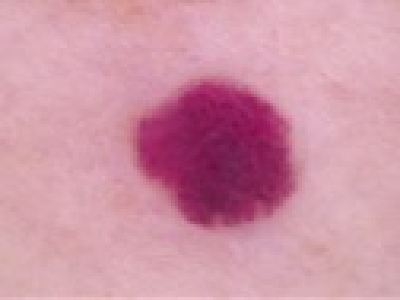

Diagnóstico: Basal cell carcinoma - Carcinoma de Células Basais
Observado:  Actinic-Keratoses.jpg >>>> Previsto:  Basal cell carcinoma - 33.77 %


,doenca_en,prob
1,Basal cell carcinoma,33.768
2,Benign keratosis-like lesions,19.014
0,Actinic keratoses,18.405
4,Melanocytic nevi,14.378
3,Dermatofibroma,11.437
5,Melanoma,2.351
6,Vascular lesions,0.646


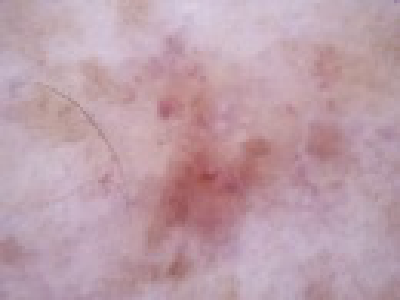

Diagnóstico: Basal cell carcinoma - Carcinoma de Células Basais
Observado:  Dematofibroma-01.jpg >>>> Previsto:  Basal cell carcinoma - 39.02 %


,doenca_en,prob
1,Basal cell carcinoma,39.016
3,Dermatofibroma,23.812
6,Vascular lesions,12.145
4,Melanocytic nevi,11.256
2,Benign keratosis-like lesions,8.590
0,Actinic keratoses,3.680
5,Melanoma,1.500


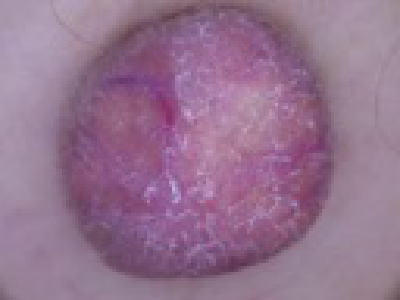

In [11]:
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
from glob import glob
base_skin_dir = 'images_test'
from IPython.display import display # to display images
imagetest_path = [x for x in glob(os.path.join(base_skin_dir, '*.jpg')) ]

print('Diagnóstico de Doenças de Pele - Versão 1.0 - By Vladimir Alencar - UEPB-LANA\n')

files = imagetest_path  
fatores_normalizacao = [127.5] # [127.5, 255]
for file in files:
    for fator_normalizacao in fatores_normalizacao:
        df = prever_doenca_de_pele(file, fator_normalizacao)
        df2 = df[ ['doenca_en', 'prob']] # 'doenca_pt']]
        df2 = df2.sort_values(by=['prob'], ascending=False)
        display(df2)
        fator_image = (100,75)
        fator_image = (200, 150)
        fator_image = (200*2, 150*2)
        img = Image.open(file).resize(fator_image) 
        display(img)
    print('='*70)

In [12]:
dict_idx_doenca

{0: 'Actinic keratoses',
 1: 'Basal cell carcinoma',
 2: 'Benign keratosis-like lesions ',
 3: 'Dermatofibroma',
 4: 'Melanocytic nevi',
 5: 'Melanoma',
 6: 'Vascular lesions'}